### Transfer Learning Notebook ###
In this notebook, we attempt to improve our model accuracy using transfer learning with ResNet50.

This notebook is based on the [Transfer Learning for Image Classification using Keras](https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8) tutorial.

In [3]:
import matplotlib.pyplot as pl
import keras
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import plotting_util
import numpy as np
from keras.models import load_model
from collections import Counter
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we load ResNet50 with include_top=False. We use the same input height and width as our baseline.

In [5]:
HEIGHT = 128
WIDTH = 128
NUM_CLASSES = 41
FC_LAYERS = [1024, 1024]
DROPOUT = 0.5
NUM_EPOCHS = 10
BATCH_SIZE = 32

base_model = ResNet50(weights='imagenet', 
                      include_top=False,
                      input_shape=(HEIGHT,WIDTH,3))

augmented_datagen = ImageDataGenerator(validation_split=0.15, rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
augmented_train_generator = augmented_datagen.flow_from_directory('../data/', subset="training", target_size=(HEIGHT,WIDTH))
augmented_valid_generator = augmented_datagen.flow_from_directory('../data/', subset="validation", target_size=(HEIGHT,WIDTH))

# base_model.summary()

Found 5211 images belonging to 41 classes.
Found 897 images belonging to 41 classes.


We add two fully connected layers with ReLu and a final softmax layer to the top of the model:

In [6]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

def build_finetune_model(base_model, dropout, fc_layers, num_classes, trainable=False):
    for layer in base_model.layers:
        layer.trainable = trainable

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

model = build_finetune_model(base_model, 
                             dropout=DROPOUT, 
                             fc_layers=FC_LAYERS, 
                             num_classes=NUM_CLASSES)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [12]:
adam = Adam(lr=0.00001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_list = [EarlyStopping(patience=2),
                  ModelCheckpoint(filepath='checkpoints/ResNet50.{epoch:02d}.h5', monitor=["acc"], verbose=1, mode='max')]

history = model.fit(augmented_train_generator, 
                    validation_data=augmented_valid_generator, 
                    epochs=10, 
                    steps_per_epoch=5211/32, 
                    validation_steps=897/32,
                    callbacks=callbacks_list)

Epoch 1/10
163/162 [==============================] - 534s 3s/step - loss: 4.8121 - accuracy: 0.0591 - val_loss: 4.0312 - val_accuracy: 0.0870

Epoch 00001: saving model to checkpoints/ResNet50.01.h5
Epoch 2/10
163/162 [==============================] - 520s 3s/step - loss: 3.6491 - accuracy: 0.1443 - val_loss: 4.0313 - val_accuracy: 0.0870

Epoch 00002: saving model to checkpoints/ResNet50.02.h5
Epoch 3/10
163/162 [==============================] - 522s 3s/step - loss: 3.1981 - accuracy: 0.2228 - val_loss: 3.9886 - val_accuracy: 0.0870

Epoch 00003: saving model to checkpoints/ResNet50.03.h5
Epoch 4/10
163/162 [==============================] - 524s 3s/step - loss: 2.8878 - accuracy: 0.2984 - val_loss: 3.6252 - val_accuracy: 0.0870

Epoch 00004: saving model to checkpoints/ResNet50.04.h5
Epoch 5/10
163/162 [==============================] - 522s 3s/step - loss: 2.6156 - accuracy: 0.3621 - val_loss: 4.2300 - val_accuracy: 0.0870

Epoch 00005: saving model to checkpoints/ResNet50.05.h5


This model is overfitting to the training data, strangely, the validation accuracy never increases. Let's try increasing the learning rate.

In [13]:
adam_lr = Adam(lr=3e-4)
model_lr = build_finetune_model(base_model, 
                                dropout=DROPOUT, 
                                fc_layers=FC_LAYERS, 
                                num_classes=NUM_CLASSES)
model_lr.compile(adam_lr, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_list_lr = [EarlyStopping(patience=2),
                     ModelCheckpoint(filepath='checkpoints/ResNet50LR.{epoch:02d}.h5', monitor=["acc"], verbose=1, mode='max')]

history_lr = model_lr.fit(augmented_train_generator, 
                          validation_data=augmented_valid_generator, 
                          epochs=10, 
                          steps_per_epoch=5211/32, 
                          validation_steps=897/32,
                          callbacks=callbacks_list_lr)

Epoch 1/10
163/162 [==============================] - 531s 3s/step - loss: 3.0670 - accuracy: 0.3268 - val_loss: 4.3479 - val_accuracy: 0.0479

Epoch 00001: saving model to checkpoints/ResNet50LR.01.h5
Epoch 2/10
163/162 [==============================] - 515s 3s/step - loss: 1.7991 - accuracy: 0.5594 - val_loss: 1.7557 - val_accuracy: 0.0479

Epoch 00002: saving model to checkpoints/ResNet50LR.02.h5
Epoch 3/10
163/162 [==============================] - 514s 3s/step - loss: 1.4224 - accuracy: 0.6500 - val_loss: 4.1542 - val_accuracy: 0.0479

Epoch 00003: saving model to checkpoints/ResNet50LR.03.h5
Epoch 4/10
163/162 [==============================] - 512s 3s/step - loss: 1.1784 - accuracy: 0.7031 - val_loss: 4.0409 - val_accuracy: 0.0479

Epoch 00004: saving model to checkpoints/ResNet50LR.04.h5


The validation accuracy went down, but still stays the same through all epochs. What is happening here?

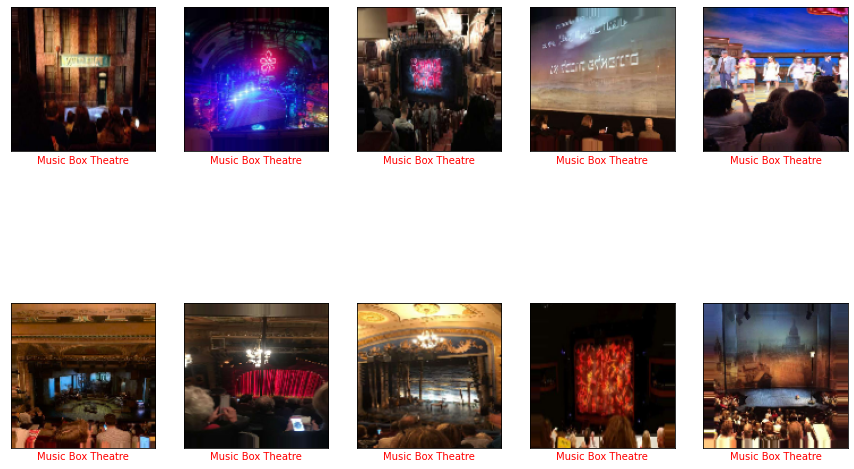

In [15]:
model_lr = load_model('checkpoints/ResNet50LR.04.h5')

valid_examples = augmented_valid_generator.next()

classifications = []

for im in valid_examples[0]:
    im_reshaped = tf.reshape(im, [-1, 128, 128, 3])
    one_hot = np.zeros((42))
    one_hot[np.argmax(model_lr.predict(np.expand_dims(im, axis=0)))] = 1
    classifications.append(one_hot)

plotting_util.plot_classification_examples(classifications,valid_examples[1],valid_examples[0])

Visualizing the predictions, it seems to be predicting Music Box Theatre for every input. Music Box Theatre examples probably make up 4.8% of the dataset. What about the previous model?

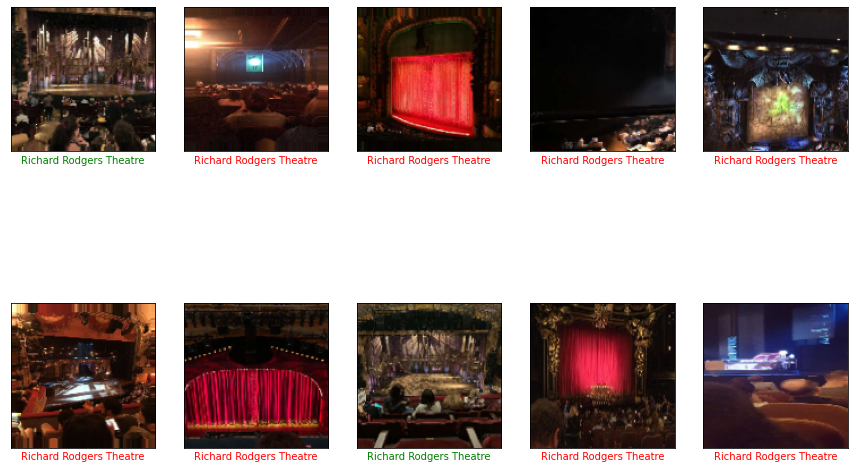

In [21]:
classifications = []

for im in valid_examples[0]:
    im_reshaped = tf.reshape(im, [-1, 128, 128, 3])
    one_hot = np.zeros((42))
    one_hot[np.argmax(model.predict(np.expand_dims(im, axis=0)))] = 1
    classifications.append(one_hot)

plotting_util.plot_classification_examples(classifications,valid_examples[1],valid_examples[0])

Same problem! The Richard Rodgers Theatre makes up 8.7% of the dataset. Some searching on StackOverflow seems to indicate that the model is only predicting one class because the features predicted from the previous layers do not affect the input in a meaningful way. We should try making the other layers trainable:

In [7]:
adam_train = Adam(lr=3e-4)
model_train = build_finetune_model(base_model, 
                                   dropout=DROPOUT, 
                                   fc_layers=FC_LAYERS, 
                                   num_classes=NUM_CLASSES,
                                   trainable=True)
model_train.compile(adam_train, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_list_train = [EarlyStopping(patience=2),
                        ModelCheckpoint(filepath='checkpoints/ResNet50Train.{epoch:02d}.h5', monitor=["acc"], verbose=1, mode='max')]

history_train = model_train.fit(augmented_train_generator, 
                                validation_data=augmented_valid_generator, 
                                epochs=10, 
                                steps_per_epoch=5211/32, 
                                validation_steps=897/32,
                                callbacks=callbacks_list_train)

Epoch 1/10
163/162 [==============================] - 2277s 14s/step - loss: 2.4354 - accuracy: 0.4750 - val_loss: 6.1653 - val_accuracy: 0.0379

Epoch 00001: saving model to checkpoints/ResNet50Train.01.h5
Epoch 2/10
163/162 [==============================] - 2137s 13s/step - loss: 1.0778 - accuracy: 0.7356 - val_loss: 5.3937 - val_accuracy: 0.0468

Epoch 00002: saving model to checkpoints/ResNet50Train.02.h5
Epoch 3/10
163/162 [==============================] - 2111s 13s/step - loss: 0.8586 - accuracy: 0.7997 - val_loss: 4.6249 - val_accuracy: 0.0346

Epoch 00003: saving model to checkpoints/ResNet50Train.03.h5
Epoch 4/10
163/162 [==============================] - 1549s 10s/step - loss: 0.6053 - accuracy: 0.8469 - val_loss: 2.7828 - val_accuracy: 0.0624

Epoch 00004: saving model to checkpoints/ResNet50Train.04.h5
Epoch 5/10
163/162 [==============================] - 1160s 7s/step - loss: 0.4274 - accuracy: 0.8902 - val_loss: 4.5383 - val_accuracy: 0.3913

Epoch 00005: saving model t

Well, this is getting much higher accuracy than the previous models. Classifying some validation set examples seems to show it is making reasonable predictions, as opposed to guessing the same theater for each example.

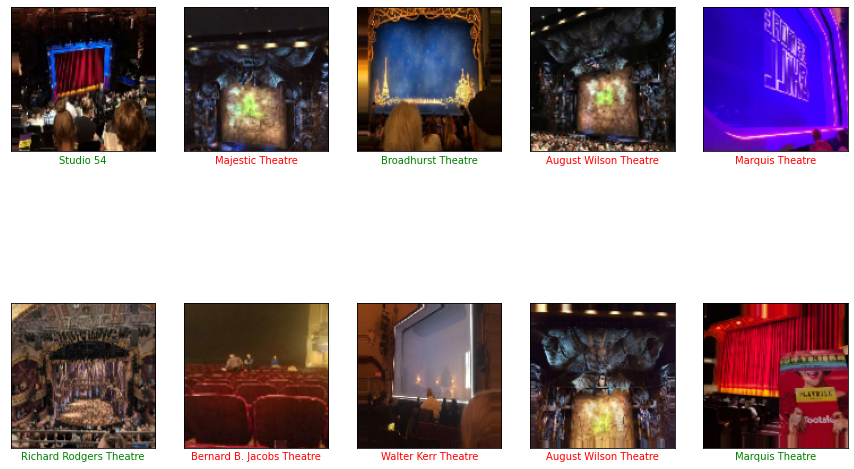

In [10]:
classifications = []

valid_examples = augmented_valid_generator.next()

for im in valid_examples[0]:
    im_reshaped = tf.reshape(im, [-1, 128, 128, 3])
    one_hot = np.zeros((42))
    one_hot[np.argmax(model_train.predict(np.expand_dims(im, axis=0)))] = 1
    classifications.append(one_hot)

plotting_util.plot_classification_examples(classifications,valid_examples[1],valid_examples[0])

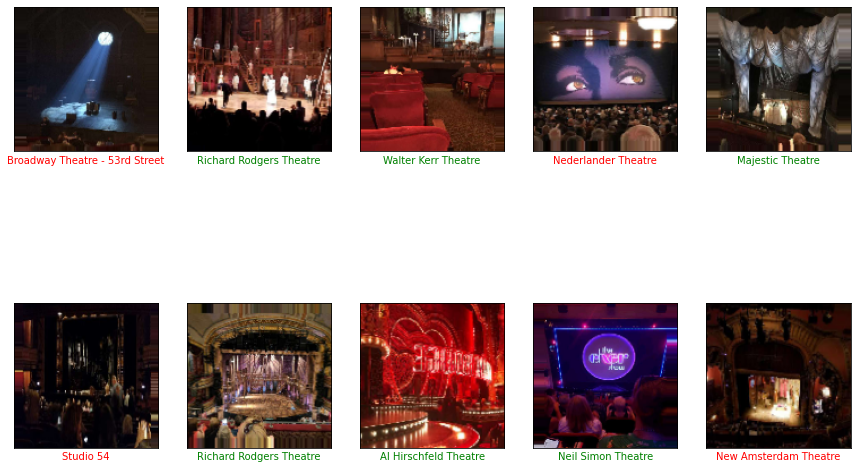

In [11]:
classifications = []

valid_examples = augmented_valid_generator.next()

for im in valid_examples[0]:
    im_reshaped = tf.reshape(im, [-1, 128, 128, 3])
    one_hot = np.zeros((42))
    one_hot[np.argmax(model_train.predict(np.expand_dims(im, axis=0)))] = 1
    classifications.append(one_hot)

plotting_util.plot_classification_examples(classifications,valid_examples[1],valid_examples[0])

Try some test examples:

Found 5 images belonging to 3 classes.


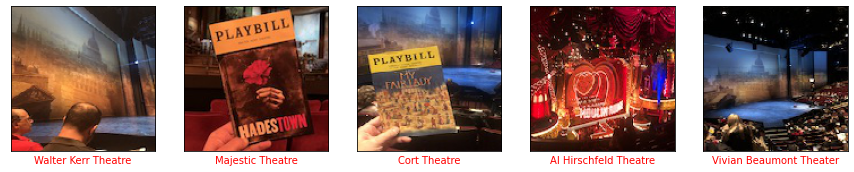

In [6]:
import plotting_util

model_train_2 = load_model('checkpoints/ResNet50Train.05.h5')

classifications = []
batch_size = 5;

theaters = open(os.path.abspath("../scripts/theaters.txt")).read().split('\n')
test_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(directory='../test-data/',
                                                                       batch_size=batch_size,
                                                                       shuffle=True,
                                                                       target_size=(HEIGHT, WIDTH),
                                                                       classes=["VivianBeaumontTheatre", "WalterKerrTheatre", "AlHirschfeldTheatre"])

test_examples = test_data_gen.next()

for im in test_examples[0]:
    im_reshaped = tf.reshape(im, [-1, 128, 128, 3])
    one_hot = np.zeros((42))
    one_hot[np.argmax(model_train_2.predict(np.expand_dims(im, axis=0)))] = 1
    classifications.append(one_hot)

plotting_util.plot_classification_examples(classifications,test_examples[1],test_examples[0],count=batch_size)

The model also has 40% accuracy on the test set. However, it's still falling into the same trap as the previous models where it only predicts the most common classes. This is because the training set is unbalanced. Balancing the loss function using class_weight can potentially help with this. First, we tried applying a weight of 1 to the class with the highest number of images and a weight of the log of the proportion of the highest number of images to the number per other class can hopefully even out the loss function (to smooth out the weights):

In [7]:
counter = Counter(augmented_train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : (np.log(max_val/num_images) + 1) for class_id, num_images in counter.items()}                     
print(class_weights)

{0: 1.4606515236754551, 1: 3.5472105331241552, 2: 3.2524109929035103, 3: 1.829559036049822, 4: 2.912903852587143, 5: 2.6252217801353623, 6: 3.4136791404996325, 7: 2.1053463208494536, 8: 2.189903708877517, 9: 1.9726598796904953, 10: 2.720531959939687, 11: 3.7013612129514133, 12: 2.7331107421465473, 13: 2.3489684035072043, 14: 2.2197566720271977, 15: 1.5931702579855918, 17: 2.439119500501502, 18: 2.1258248521929946, 19: 3.0772069038784196, 20: 2.4204273674893493, 21: 2.6027489242833037, 22: 2.315066851831523, 23: 1.617761661122914, 24: 2.2903742392411512, 25: 2.5807700175645287, 26: 2.527847616110186, 27: 1.5931702579855918, 28: 2.85406335256421, 29: 2.720531959939687, 30: 2.331873970147904, 31: 2.227361271412417, 32: 1.0, 33: 3.883682769745368, 34: 1.804241228065532, 35: 1.8398684057086832, 36: 4.058036156890146, 37: 2.683717986816971, 38: 3.0421155840671497, 39: 1.5457305329140312, 40: 1.7507004611375023}


In [8]:
adam_balance = Adam(lr=3e-4)
model_balance = build_finetune_model(base_model, 
                                     dropout=DROPOUT, 
                                     fc_layers=FC_LAYERS, 
                                     num_classes=NUM_CLASSES,
                                     trainable=True)
model_balance.compile(adam_balance, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_list_balance = [EarlyStopping(patience=2),
                          ModelCheckpoint(filepath='checkpoints/ResNet50Balance.{epoch:02d}.h5', monitor=["acc"], verbose=1, mode='max')]

history_balance = model_balance.fit(augmented_train_generator, 
                                    validation_data=augmented_valid_generator, 
                                    epochs=10, 
                                    steps_per_epoch=5211/32, 
                                    validation_steps=897/32,
                                    callbacks=callbacks_list_balance,
                                    class_weight=class_weights)

Epoch 1/10
163/162 [==============================] - 1272s 8s/step - loss: 5.6555 - accuracy: 0.4333 - val_loss: 7.4739 - val_accuracy: 0.0323

Epoch 00001: saving model to checkpoints/ResNet50Balance.01.h5
Epoch 2/10
163/162 [==============================] - 1216s 7s/step - loss: 2.5952 - accuracy: 0.7250 - val_loss: 3.7655 - val_accuracy: 0.0067

Epoch 00002: saving model to checkpoints/ResNet50Balance.02.h5
Epoch 3/10
163/162 [==============================] - 1210s 7s/step - loss: 1.8044 - accuracy: 0.8075 - val_loss: 4.6366 - val_accuracy: 0.0234

Epoch 00003: saving model to checkpoints/ResNet50Balance.03.h5
Epoch 4/10
163/162 [==============================] - 1184s 7s/step - loss: 2.1545 - accuracy: 0.7855 - val_loss: 5.0564 - val_accuracy: 0.0401

Epoch 00004: saving model to checkpoints/ResNet50Balance.04.h5


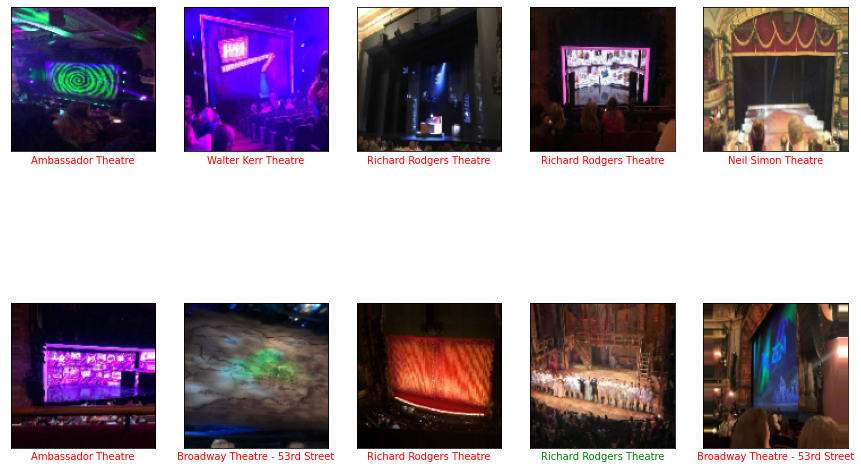

In [12]:
classifications = []

valid_examples = augmented_valid_generator.next()

for im in valid_examples[0]:
    im_reshaped = tf.reshape(im, [-1, 128, 128, 3])
    one_hot = np.zeros((42))
    one_hot[np.argmax(model_balance.predict(np.expand_dims(im, axis=0)))] = 1
    classifications.append(one_hot)

plotting_util.plot_classification_examples(classifications,valid_examples[1],valid_examples[0])

This still isn't doing too great. In other notebooks, we'll explore two paths forward:
1. Using the weights from the highest scoring model: checkpoints/ResNet50Train.05.h5, and training from there with the weighted classes
2. Limiting the training set to the top 10-20 classes to create a more balanced dataset.